# Bee Monitoring & Counting with YOLOv11

This notebook demonstrates an automated system for monitoring honey bee activity. The goal is to provide real-time insights into hive health and behavior by classifying and counting different types of bees. This project bridges the gap between raw video footage and actionable data for beekeepers.

### Data & Testing Sources
`Training Data:` The model was trained using a specialized dataset sourced from Roboflow, containing high-quality annotations for multiple bee classes.

`Initial Testing:` Before processing video, the model was validated using the Test Split from the original dataset to ensure accuracy on unseen images.

`Real-world Testing:` For the final video demonstration, footage was sourced from YouTube, representing various environmental conditions and hive setups.

### Assessed Classes
`Bees:` Standard workers or foragers.

`Pollen Bees:` Foragers returning with visible pollen loads (crucial for pollination efficiency metrics).

`Drones:` Male bees, generally larger with distinct eye structures.

`Queens:` The hive's mother, identified by her elongated abdomen.

In [17]:
try:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/GithubProject/bee-detection
except:
    pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GithubProject/bee-detection


In [ ]:
# Install ultralytics roboflow
!pip install ultralytics roboflow
!pip install ultralytics supervision

In [18]:
# libraries
import os
import glob
import cv2
import numpy as np
import supervision as sv
from datetime import datetime
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display, Image

In [ ]:
rf = Roboflow(api_key="") # Your API Key
project = rf.workspace("project_name").project("project_id")
version = project.version(1) # eg: 1, 2 or 3
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Bee-Detection-1 in yolov8:: 100%|██████████| 4274/4274 [00:49<00:00, 86.05it/s]


In [ ]:
# Settings -> T4 GPU)
model = YOLO('yolov8n.pt')

# Training
model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=100,
    imgsz=640,
    plots=True,
    patience=20
)

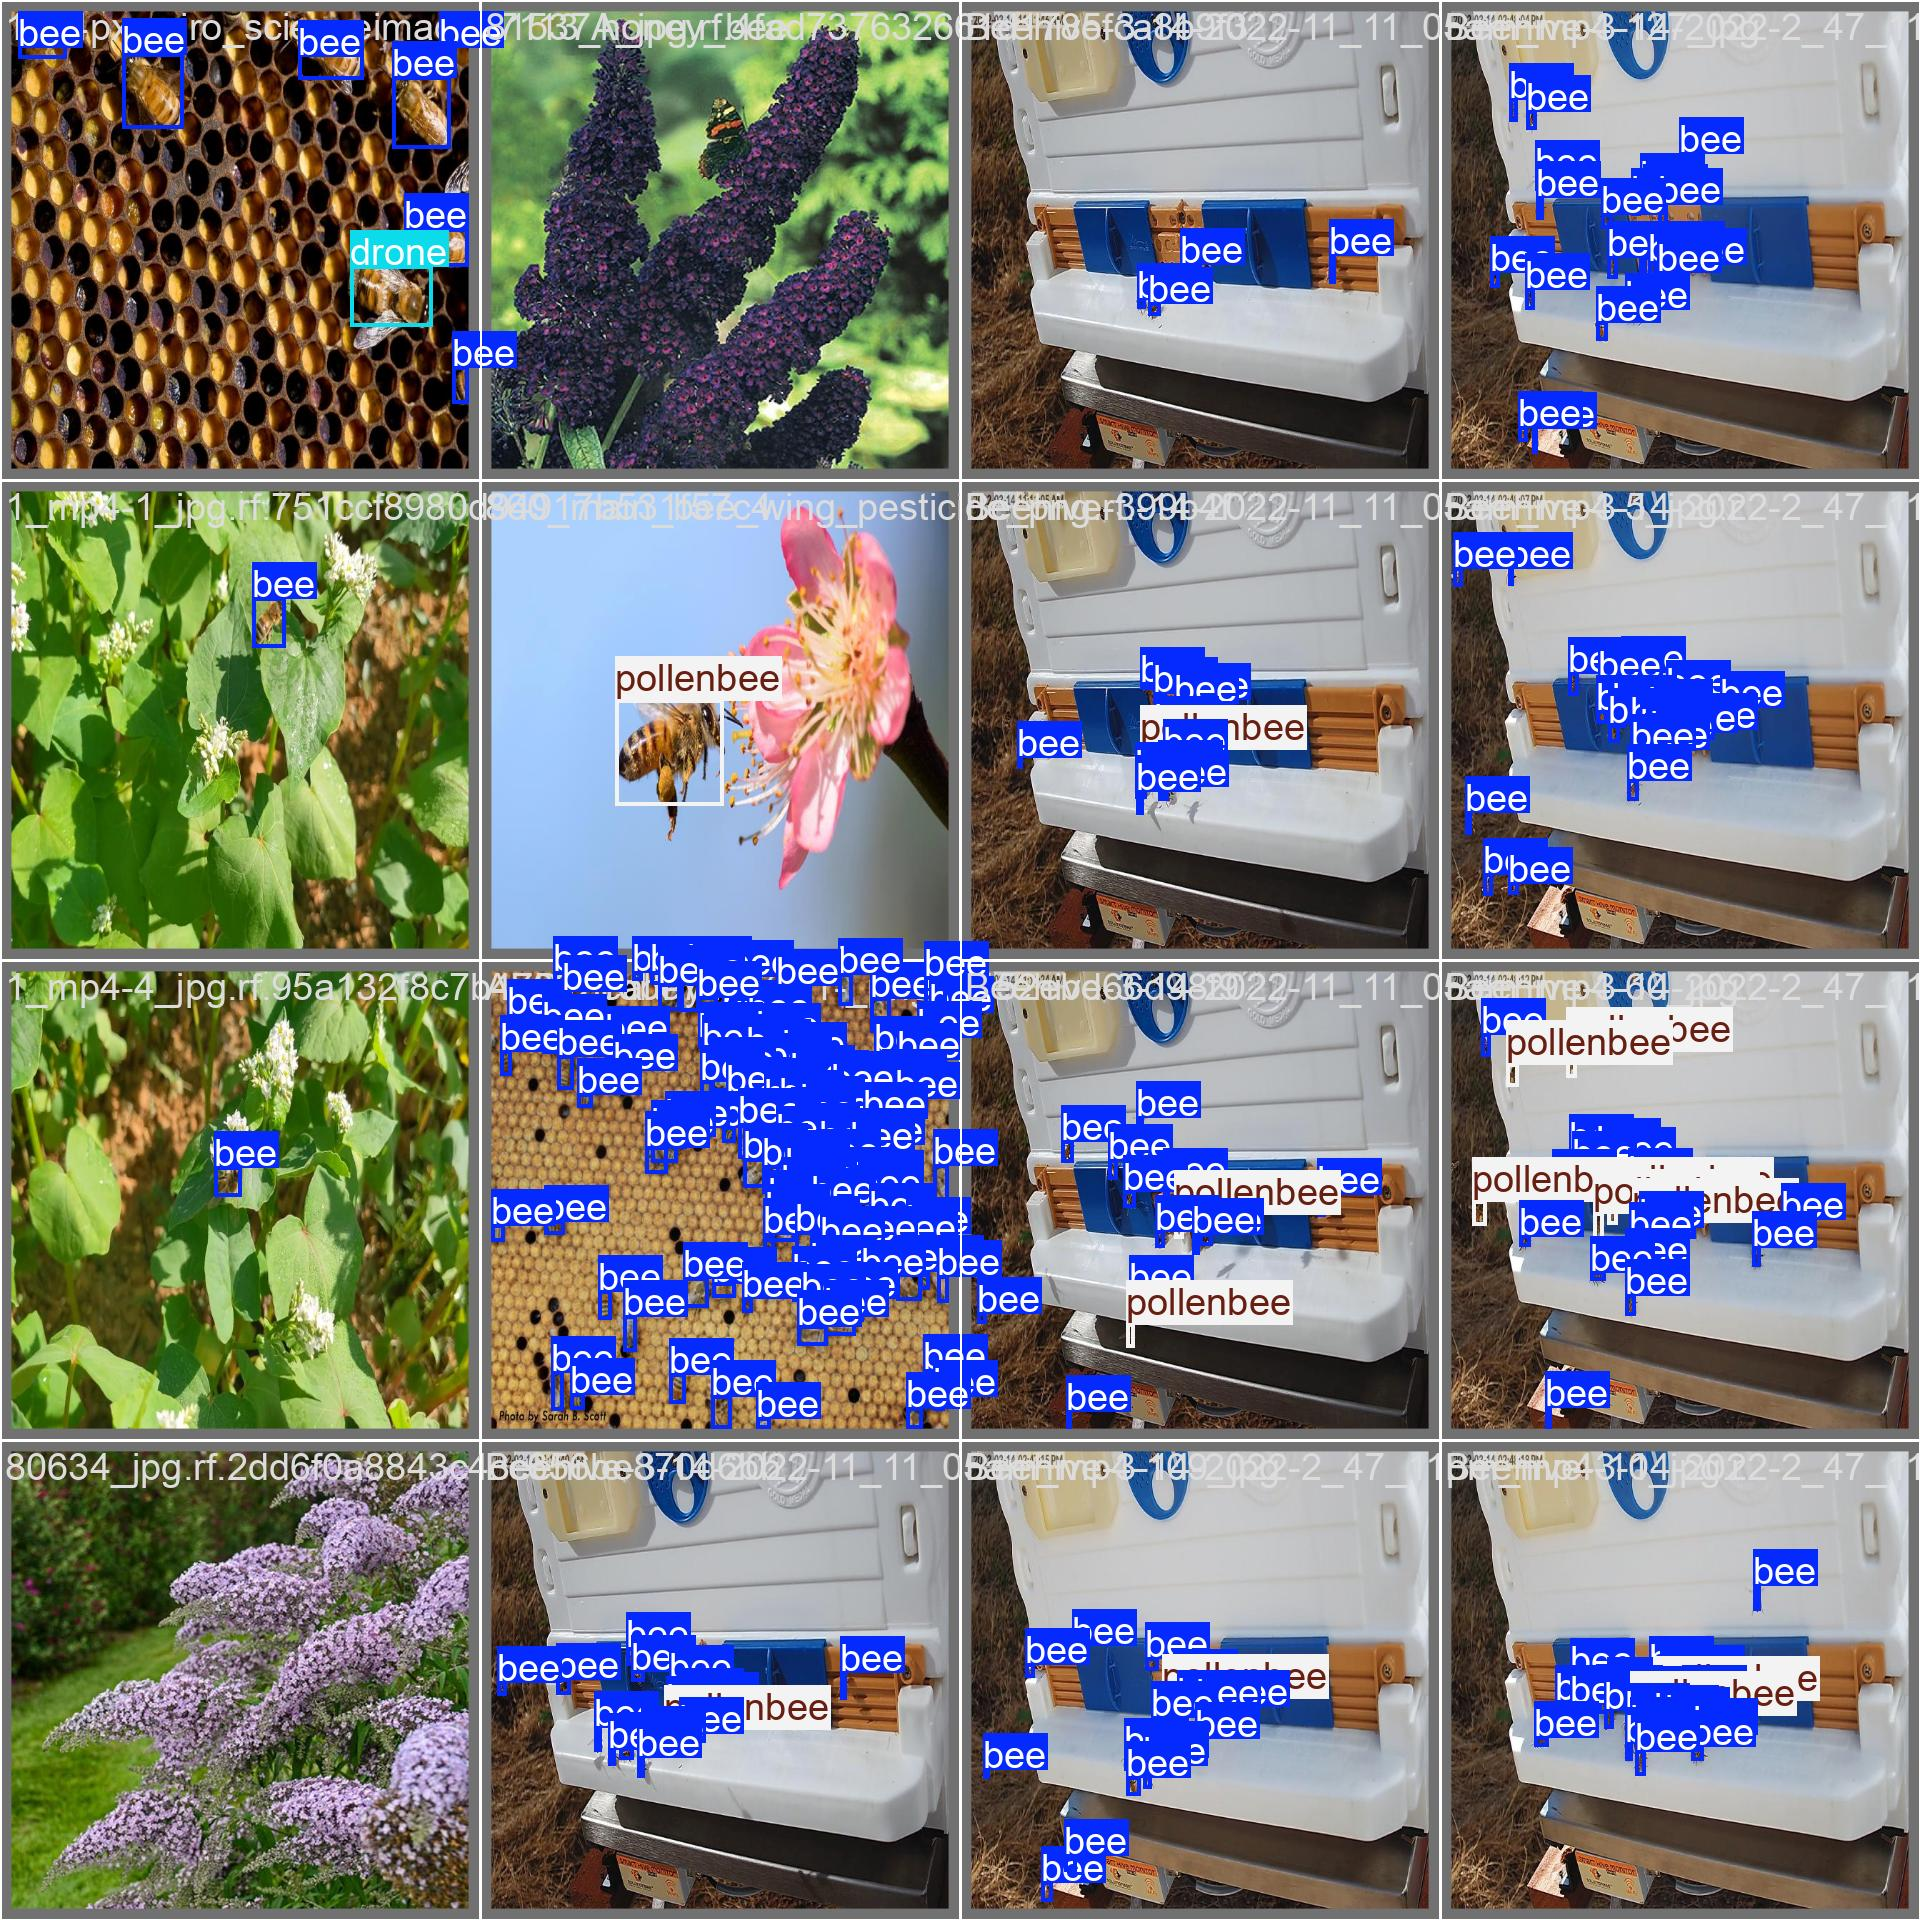

In [ ]:
# Some images from the "validation set" with the AI ​​predictions
val_images = glob.glob(f"runs/detect/train/val_batch0_labels.jpg")
for img in val_images:
    display(Image(filename=img))

## Model testing


image 1/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/1525284664935_jpeg.rf.690121de76fbdfce14b5cb6b741334cd.jpg: 640x640 (no detections), 7.7ms
image 2/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/17345754_337326da38_w_jpg.rf.ed87e3af05b91c325f264547832e8ac8.jpg: 640x640 5 bees, 29.0ms
image 3/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/1_mp4-12_jpg.rf.ef0c3dfe3aa3b395601878dfa4e76bc0.jpg: 640x640 (no detections), 7.2ms
image 4/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/1_mp4-3_jpg.rf.7d8fb39df59d47d8aca5c202698c1327.jpg: 640x640 1 bee, 7.2ms
image 5/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/2016-03-15-04-09-38-1024x673_jpg.rf.3efc08769417776b5e2383822323b982.jpg: 640x640 35 bees, 2 queens, 7.2ms
image 6/122 /content/drive/MyDrive/GithubProject/bee-detection/Bee-Detection-1/test/images/202201

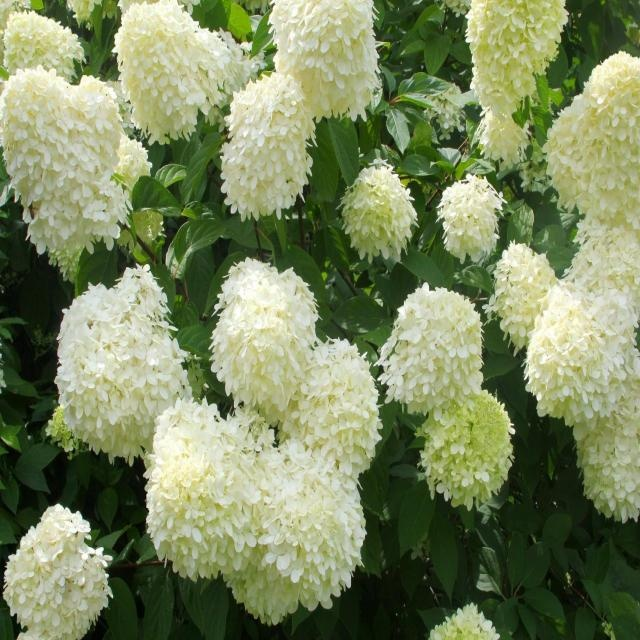

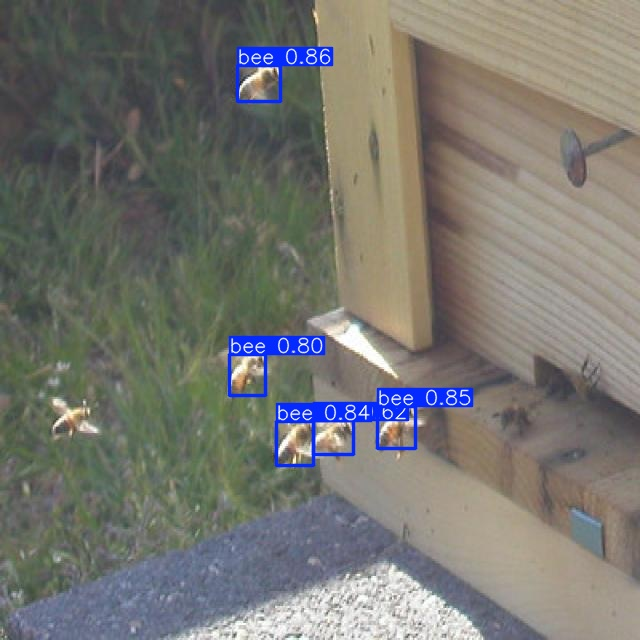

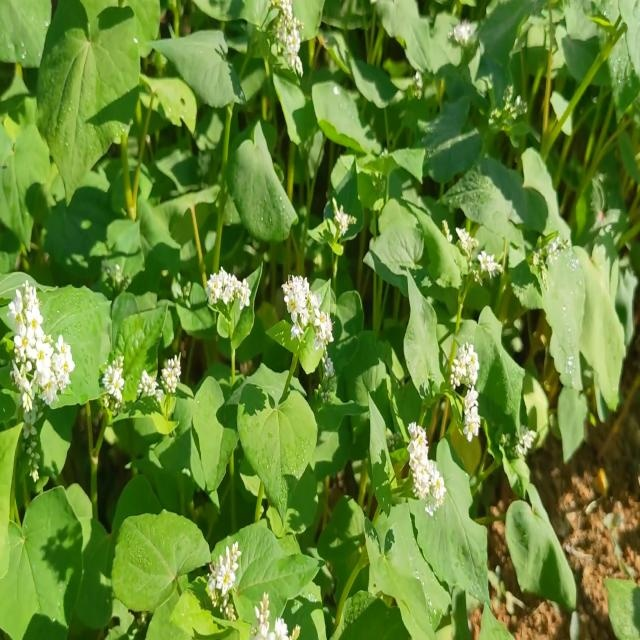

In [ ]:
# Load saved model "best.pt"
model = YOLO('runs/detect/train/weights/best.pt')

# Make a prediction on an image from the "test set"
# The "test set" is an image that the AI ​​has never seen before
results = model.predict(source=f"{dataset.location}/test/images", save=True, conf=0.25)

latest_prediction = max(glob.glob('runs/detect/predict*/'), key=os.path.getmtime)
predicted_images = glob.glob(f"{latest_prediction}/*.jpg")

for img in predicted_images[:3]: # 3 first images
    display(Image(filename=img))

## Video inference

In [22]:
# Load model
model = YOLO('runs/detect/train/weights/best.pt')
tracker = sv.ByteTrack()

# Memory & Logging
counted_ids = set()
queen_evidence = {}
queen_logs = []
stats = {"bee": 0, "pollenbee": 0, "drone": 0}

def process_frame(frame: np.ndarray, index: int) -> np.ndarray:
    h, w, _ = frame.shape
    now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

    results = model(frame, verbose=False, conf=0.4)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    if detections.tracker_id is not None:
        for i, (class_id, tracker_id) in enumerate(zip(detections.class_id, detections.tracker_id)):
            class_name = model.model.names[class_id].lower()
            conf_score = detections.confidence[i]

            if "queen" in class_name:
                x1, y1, x2, y2 = detections.xyxy[i]
                bw, bh = x2 - x1, y2 - y1
                ratio = bh / bw if bw > 0 else 0
                queen_evidence[tracker_id] = queen_evidence.get(tracker_id, 0) + 1
                if queen_evidence[tracker_id] == 15:
                    queen_logs.append(f"Q#{tracker_id} {datetime.now().strftime('%H:%M')} (R:{ratio:.1f})")

            elif tracker_id not in counted_ids:
                if class_name in stats:
                    stats[class_name] += 1
                    counted_ids.add(tracker_id)

    # Annotation (Video)
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=0.4, text_padding=5)

    # ID + NAME + CONF
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for class_id, tracker_id, confidence
        in zip(detections.class_id, detections.tracker_id, detections.confidence)
    ]

    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Dashboard (Bottom Bar)
    overlay = annotated_frame.copy()
    cv2.rectangle(overlay, (0, h - 150), (w, h), (0, 0, 0), -1)
    annotated_frame = cv2.addWeighted(overlay, 0.6, annotated_frame, 0.4, 0)

    # Stats
    for i, (name, count) in enumerate(stats.items()):
        cv2.putText(annotated_frame, f"{name.upper()}: {count}", (30, h - 110 + (i * 35)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Queen Logs
    cv2.putText(annotated_frame, "SUSPICIOUS QUEEN EVENTS:", (w//3, h - 110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    for i, log in enumerate(queen_logs[-3:]):
        cv2.putText(annotated_frame, f"> {log}", (w//3 + 10, h - 80 + (i * 25)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Time & Logo
    cv2.putText(annotated_frame, now, (int(w*0.7), h - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)
    cv2.putText(annotated_frame, "Bee Monitor AI", (int(w*0.7), h - 110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    return annotated_frame

# Execute
sv.process_video(source_path="video/Honey_Bee_Hive_Entrance.mp4",
                 target_path="output/Honey_Bee_Hive_Final_Bebe.mp4",
                 callback=process_frame)